In [ ]:
# import Library
import glob
import pandas as pd
import numpy as np
import os

# 0. Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Load Dataset

In [ ]:
DATA_DIR = '/content/drive/MyDrive/CICIDS2017'

In [ ]:
# baca csv file
csv_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.csv")))

# buat dataframe
all_frame = []
for f_path in csv_files:
  df = pd.read_csv(f_path)
  print(f"{os.path.basename(f_path)}: {df.shape}")
  all_frame.append(df)

# hapus variabel yang tidak di perlukan
del csv_files
del df
del f_path

Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv: (225745, 79)
Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv: (286467, 79)
Friday-WorkingHours-Morning.pcap_ISCX.csv: (191033, 79)
Monday-WorkingHours.pcap_ISCX.csv: (529918, 79)
Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv: (288602, 79)
Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv: (170366, 79)
Tuesday-WorkingHours.pcap_ISCX.csv: (445909, 79)
Wednesday-workingHours.pcap_ISCX.csv: (692703, 79)


In [ ]:
# satukan dataframe
raw_df = pd.concat(all_frame, ignore_index=True)
print(raw_df.shape)

# hapus variable yang tidak diperlukan
del all_frame

(2830743, 79)


# 2. Ringkasan dataset

In [ ]:
# raw_df.head()

In [ ]:
# raw_df.sample(n=15, random_state=42)

In [ ]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max         

In [ ]:
missing = raw_df.isnull().sum()
missing = missing[missing > 0]

missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': (missing / len(raw_df)) * 100
})

print(missing_df)

              Missing Count  Missing %
Flow Bytes/s           1358   0.047973


In [ ]:
raw_df[' Label'].value_counts()

,count
Label,
BENIGN,2273097
DoS Hulk,231073
PortScan,158930
DDoS,128027
DoS GoldenEye,10293
FTP-Patator,7938
SSH-Patator,5897
DoS slowloris,5796
DoS Slowhttptest,5499


# 3. Data Cleaning

In [ ]:
# hapus spasi dari header
raw_df.columns = raw_df.columns.str.strip()

In [ ]:
# cek jumlah duplikat
print(f"Jumlah duplikat: {raw_df.duplicated().sum()}")

Jumlah duplikat: 308381


In [ ]:
# hapus duplikat dan keep=first
raw_df = raw_df.drop_duplicates()
raw_df.shape

(2522362, 79)

In [ ]:
# buat hash perkolom -> hash dijumlahkan -> kalo kolomnya identik hasnya akan sama
col_hash = raw_df.apply(lambda col: pd.util.hash_pandas_object(col, index=False).sum())
# buat dataframe hasil hash
df_hash = col_hash.reset_index()
df_hash.columns = ['col_name', 'hash_value']
# kumpulkan kolom yang punya hash sama
duplicate_groups = df_hash.groupby('hash_value')['col_name'].apply(list)
# panggil yang > 1
duplicate_groups = duplicate_groups[duplicate_groups.str.len() > 1]
for grup in duplicate_groups:
    print(grup)

['Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']
['Fwd URG Flags', 'CWE Flag Count']
['Total Fwd Packets', 'Subflow Fwd Packets']
['Total Backward Packets', 'Subflow Bwd Packets']
['Fwd PSH Flags', 'SYN Flag Count']
['Fwd Header Length', 'Fwd Header Length.1']


In [ ]:
# hapus kolom duplikat
raw_df = raw_df.loc[:, ~col_hash.duplicated()]
print(raw_df.shape)
# hapus variabel yang tidak di perlukan
del col_hash
del df_hash
del duplicate_groups
del grup

(2522362, 67)


In [ ]:
inf_count = (raw_df == np.inf).sum() + (raw_df == -np.inf).sum()
# panggil kolom yang inf > 0
print(inf_count[inf_count > 0])
# hapus variabel yang tidak diperlukan
del inf_count

Flow Bytes/s      1211
Flow Packets/s    1564
dtype: int64


In [ ]:
# ubah inf jadi nan
raw_df = raw_df.replace([np.inf, -np.inf], np.nan)

In [ ]:
# cari missing value/nan per Label -> bandingkan setelah di hapus
before = raw_df['Label'].value_counts()
after  = raw_df.dropna()['Label'].value_counts()

cek_label = pd.DataFrame({'Before': before, 'After': after})
cek_label['Lost'] = cek_label['Before'] - cek_label['After']
cek_label['Lost %'] = (cek_label['Lost'] / cek_label['Before'] * 100).round(2)
print(cek_label)
# hapus variabel yang tidak di perlukan
del before
del after
del cek_label

                             Before    After  Lost  Lost %
Label                                                     
BENIGN                      2096484  2095057  1427    0.07
DoS Hulk                     172849   172846     3    0.00
DDoS                         128016   128014     2    0.00
PortScan                      90819    90694   125    0.14
DoS GoldenEye                 10286    10286     0    0.00
FTP-Patator                    5933     5931     2    0.03
DoS slowloris                  5385     5385     0    0.00
DoS Slowhttptest               5228     5228     0    0.00
SSH-Patator                    3219     3219     0    0.00
Bot                            1953     1948     5    0.26
Web Attack � Brute Force       1470     1470     0    0.00
Web Attack � XSS                652      652     0    0.00
Infiltration                     36       36     0    0.00
Web Attack � Sql Injection       21       21     0    0.00
Heartbleed                       11       11     0    0.

In [ ]:
# cari missing value per kolom
threshold = 10
miss_cek = raw_df.isnull().mean() * 100
high = miss_cek[miss_cek > threshold]

if high.empty: print("Tidak ada kolom yang missing lebih dari", threshold, "%")
print(miss_cek.sort_values(ascending=False).head(10))
# hapus variabel yang tidak di perlukan
del miss_cek
del high
del threshold

Tidak ada kolom yang missing lebih dari 10 %
Flow Packets/s                 0.062005
Flow Bytes/s                   0.062005
Destination Port               0.000000
Total Fwd Packets              0.000000
Flow Duration                  0.000000
Total Backward Packets         0.000000
Total Length of Fwd Packets    0.000000
Fwd Packet Length Min          0.000000
Fwd Packet Length Mean         0.000000
Total Length of Bwd Packets    0.000000
dtype: float64


In [ ]:
print((raw_df.isna().mean(1) * 100).describe())
print("\nTotal baris missing value:", raw_df.isna().any(axis=1).sum())

count    2.522362e+06
mean     1.850907e-03
std      7.430795e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.985075e+00
dtype: float64

Total baris missing value: 1564


In [ ]:
# missing value tidak terlalu berarti -> hapus missing value
raw_df = raw_df.dropna()
raw_df.shape

(2520798, 67)

# 4. Seleksi FItur

In [ ]:
# cek kolom yang isinya sama semua
raw_df.columns[raw_df.nunique()==1]

Index(['Bwd PSH Flags'], dtype='object')

In [ ]:
# hapus kolom yang isinya sama semua
raw_df = raw_df.drop(raw_df.columns[raw_df.nunique()==1], axis=1)
raw_df.shape

(2520798, 66)

In [ ]:
raw_df.sample(10)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
692279,53,176980,1,1,43,132,43,43,43.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
225489,53,280137,1,1,46,108,46,46,46.000000,0.000000,...,40,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
395074,7443,44,1,1,0,6,0,0,0.000000,0.000000,...,40,0.0,0.0,0,0,0.0,0.0,0,0,PortScan
2591552,443,147407,7,4,376,3508,201,0,53.714286,78.686539,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2237994,16442,20122,3,0,18,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1032477,55603,202,2,1,247,6,216,31,123.500000,130.814755,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
203674,53,30707,2,2,84,282,42,42,42.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
217679,80,23666088,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1036793,53,197,2,2,62,190,31,31,31.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1490312,443,3,2,0,53,0,53,0,26.500000,37.476659,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [ ]:
raw_df.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,2.520798e+06,2.520798e+06,2.520798e+06,2.520798e+06,2.520798e+06,2.520798e+06,2.520798e+06,2.520798e+06,2.520798e+06,2.520798e+06,...,2.520798e+06,2.520798e+06,2.520798e+06,2.520798e+06,2.520798e+06,2.520798e+06,2.520798e+06,2.520798e+06,2.520798e+06,2.520798e+06
mean,8.690590e+03,1.659161e+07,1.028174e+01,1.157280e+01,6.119477e+02,1.814440e+04,2.312292e+02,1.920349e+01,6.350497e+01,7.732347e+01,...,6.009478e+00,-3.082233e+03,9.157847e+04,4.619177e+04,1.720171e+05,6.546359e+04,9.337367e+06,5.657941e+05,9.763770e+06,8.892671e+06
std,1.901280e+04,3.523276e+07,7.944201e+02,1.056922e+03,1.058827e+04,2.398177e+06,7.563755e+02,6.079834e+01,1.955526e+02,2.968814e+02,...,6.744150e+02,1.149758e+06,6.866503e+05,4.165844e+05,1.085571e+06,6.111585e+05,2.484818e+07,4.874169e+06,2.561746e+07,2.458143e+07
min,0.000000e+00,-1.300000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-5.368707e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.300000e+01,2.080000e+02,2.000000e+00,1.000000e+00,1.200000e+01,6.000000e+00,6.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.000000e+01,5.062200e+04,2.000000e+00,2.000000e+00,6.600000e+01,1.560000e+02,4.000000e+01,2.000000e+00,3.625000e+01,0.000000e+00,...,1.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.430000e+02,5.333340e+06,6.000000e+00,5.000000e+00,3.320000e+02,9.970000e+02,2.020000e+02,3.700000e+01,5.200000e+01,7.419280e+01,...,3.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,6.553500e+04,1.200000e+08,2.197590e+05,2.919220e+05,1.290000e+07,6.554530e+08,2.482000e+04,2.325000e+03,5.940857e+03,7.125597e+03,...,2.135570e+05,1.380000e+02,1.100000e+08,7.420000e+07,1.100000e+08,1.100000e+08,1.200000e+08,7.690000e+07,1.200000e+08,1.200000e+08


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from sklearn.metrics import confusion_matrix, classification_report

# 1. dapetin fitur numerik
def get_feature_types(df, target_col='Label'):
    numeric = df.select_dtypes(include=[np.number]).columns.tolist()
    if target_col in numeric: numeric.remove(target_col)
    return numeric

# 2. korelasi dan pasangan korelasi tinggi
def simple_corr(df, numeric_features, threshold=0.85, scatter_threshold=0.98):
    # matriks korelasi
    corr = df[numeric_features].corr()
    # heatmap matriks korelasi
    plt.figure(figsize=(20, 20))
    sns.heatmap(corr, cmap='coolwarm_r', center=0, linewidths=0.5)
    plt.title('Feature Correlation Heatmap')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # pasangan korelasi
    pairs = []

    for i in range(len(corr.columns)):
        for j in range(i + 1, len(corr.columns)):
            corr_value = corr.iloc[i, j]
            if abs(corr_value) > threshold:
                f1 = corr.index[i]
                f2 = corr.columns[j]
                pairs.append((f1, f2, corr_value))
    for f1, f2, corr_value in pairs:
        print(f"{f1}  X  {f2}: {corr_value:.4f}")

    # scatter plot korelasi tinggi
    strong_pairs = []

    for f1, f2, corr_value in pairs:
        if abs(corr_value) >= scatter_threshold:
            strong_pairs.append((f1, f2, corr_value))

    if len(strong_pairs) > 0:
        n_plots = len(strong_pairs)
        n_cols = 4
        n_rows = (n_plots + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
        axes = axes.flatten()

        for i, (f1, f2, corr_value) in enumerate(strong_pairs):
            sns.scatterplot(x=df[f1], y=df[f2], ax=axes[i], color='#4FC3F7')
            axes[i].set_title(f"{f1} vs {f2} (Corr={corr_value:.2f})", fontsize=8)
            axes[i].set_xlabel(f1, fontsize=8)
            axes[i].set_ylabel(f2, fontsize=8)

        # Hapus subplot yang kosong kalau jumlah pair tidak pas dengan grid
        for j in range(len(strong_pairs), len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()

    return corr, pairs



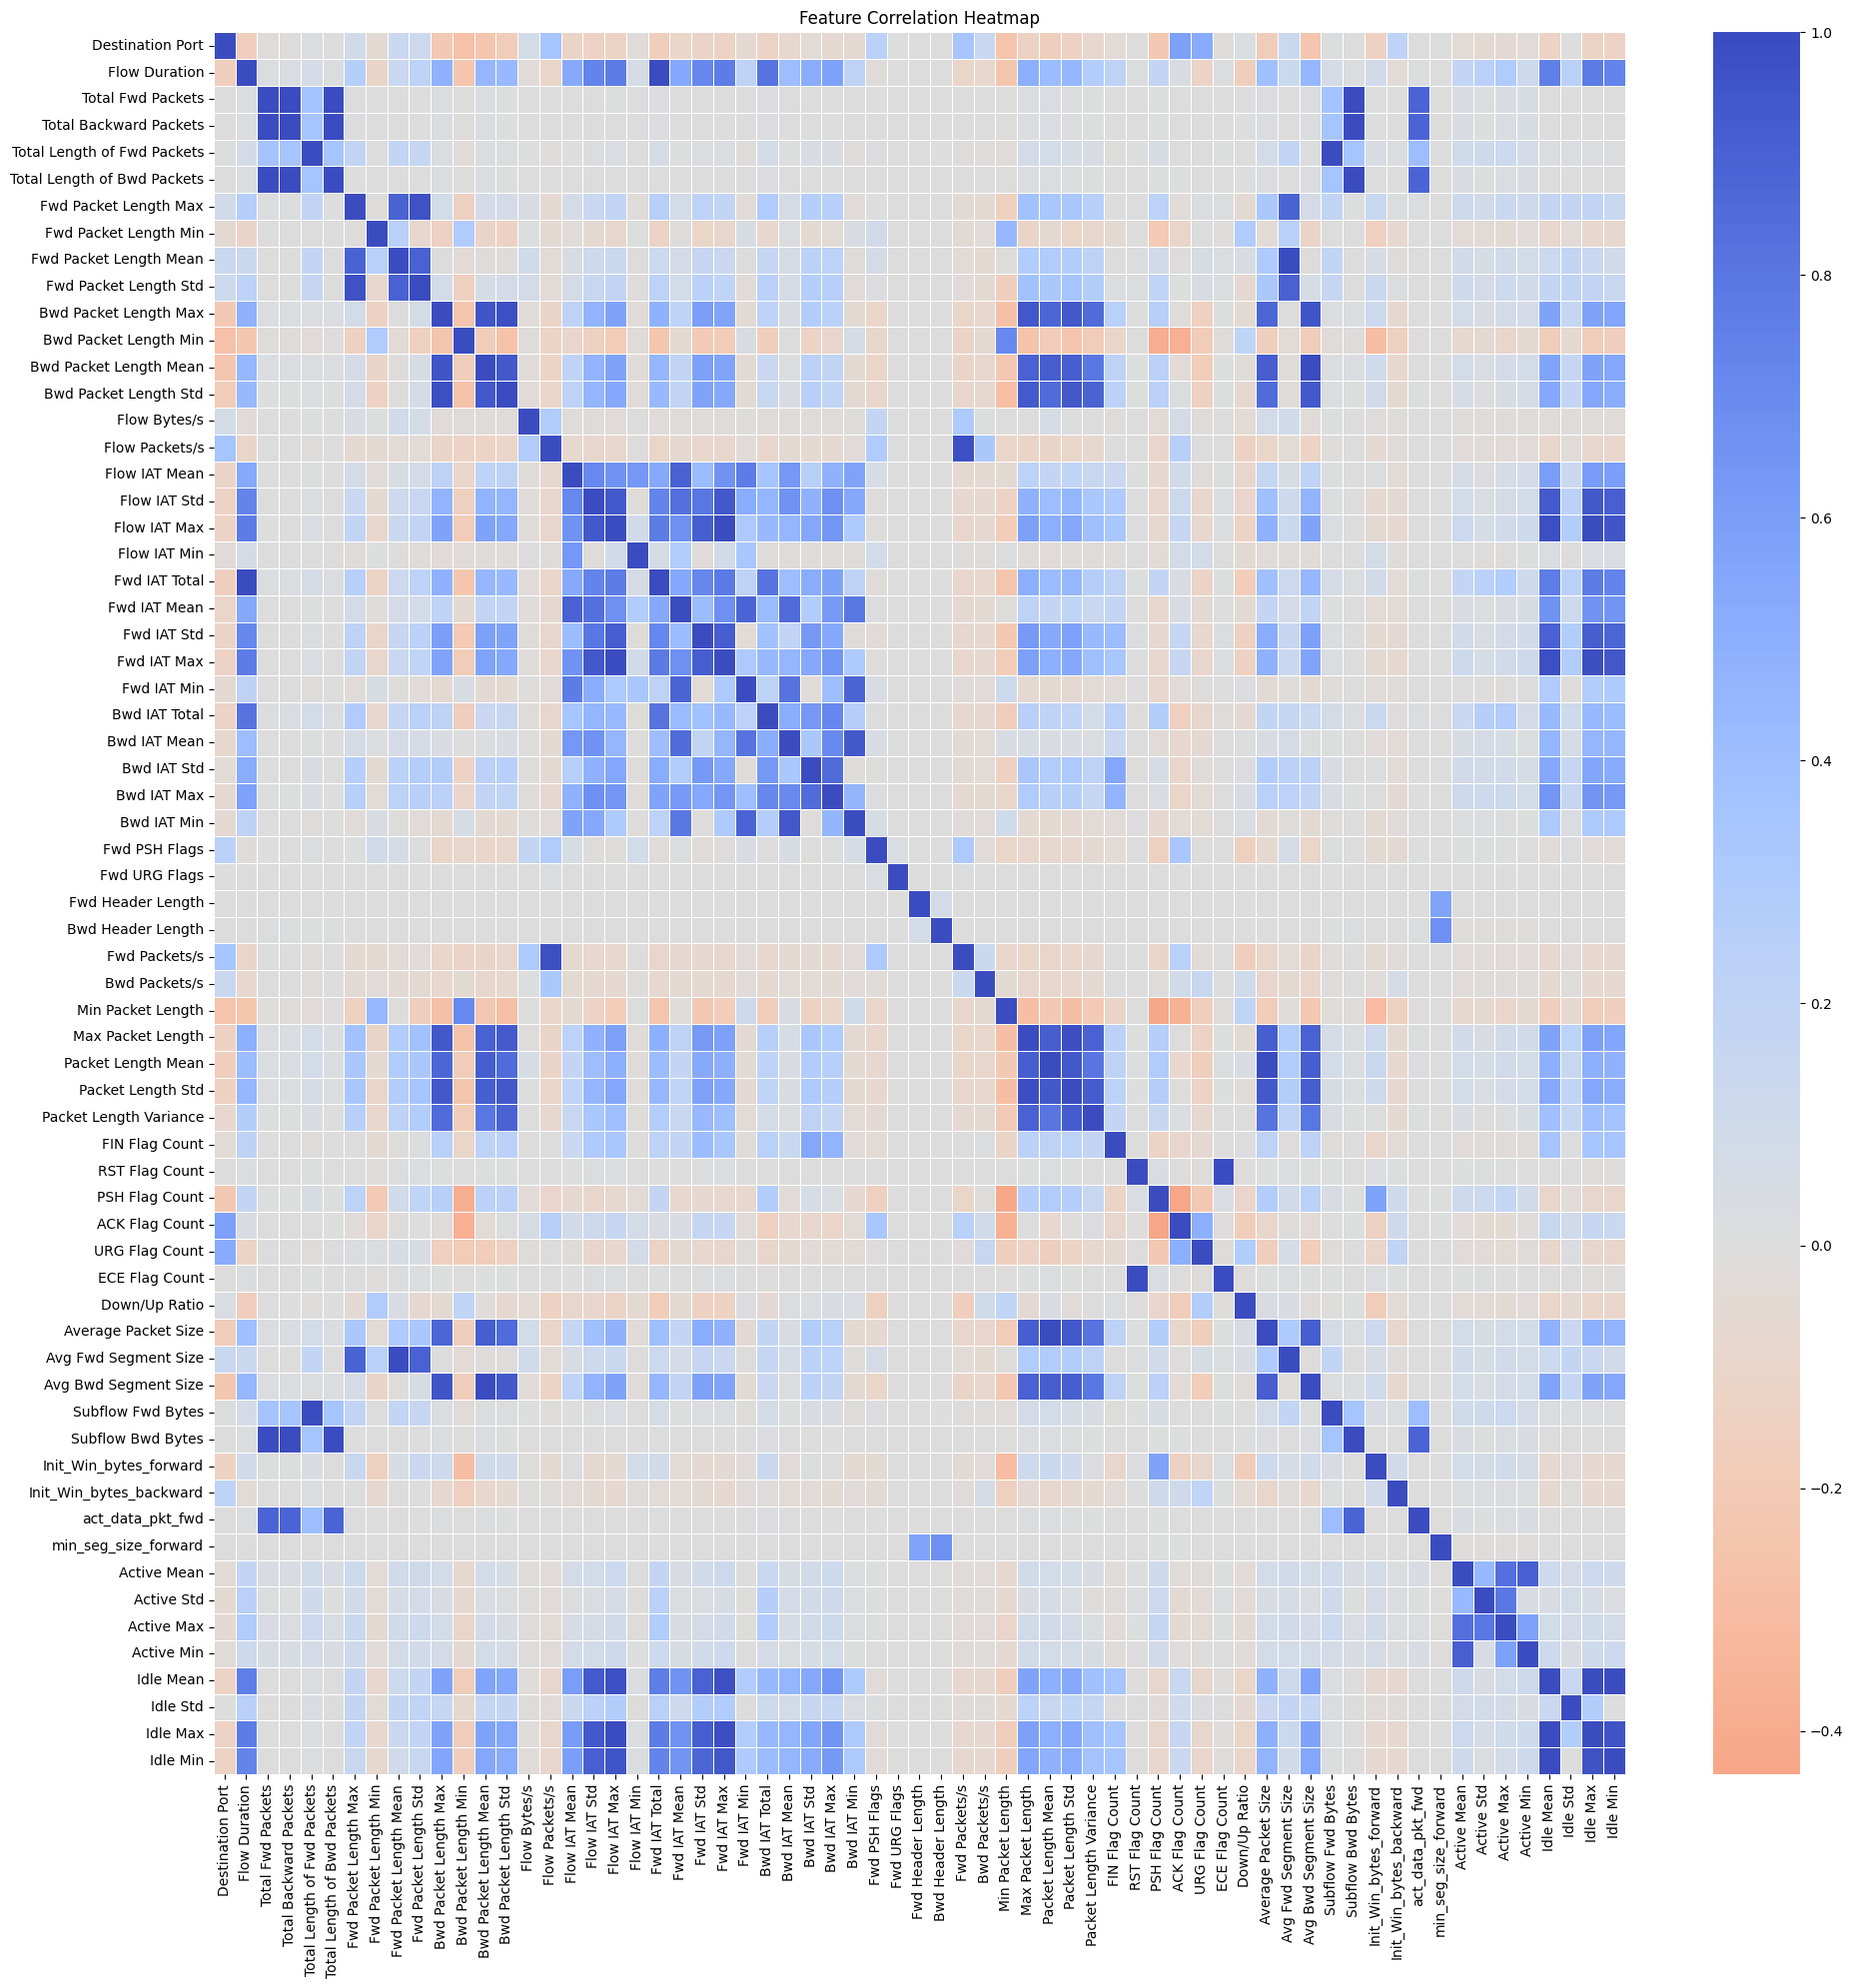

Flow Duration  X  Fwd IAT Total: 0.9985
Total Fwd Packets  X  Total Backward Packets: 0.9991
Total Fwd Packets  X  Total Length of Bwd Packets: 0.9970
Total Fwd Packets  X  Subflow Bwd Bytes: 0.9970
Total Fwd Packets  X  act_data_pkt_fwd: 0.8874
Total Backward Packets  X  Total Length of Bwd Packets: 0.9944
Total Backward Packets  X  Subflow Bwd Bytes: 0.9944
Total Backward Packets  X  act_data_pkt_fwd: 0.8826
Total Length of Fwd Packets  X  Subflow Fwd Bytes: 1.0000
Total Length of Bwd Packets  X  Subflow Bwd Bytes: 1.0000
Total Length of Bwd Packets  X  act_data_pkt_fwd: 0.8840
Fwd Packet Length Max  X  Fwd Packet Length Mean: 0.8889
Fwd Packet Length Max  X  Fwd Packet Length Std: 0.9685
Fwd Packet Length Max  X  Avg Fwd Segment Size: 0.8889
Fwd Packet Length Mean  X  Fwd Packet Length Std: 0.8976
Fwd Packet Length Mean  X  Avg Fwd Segment Size: 1.0000
Fwd Packet Length Std  X  Avg Fwd Segment Size: 0.8976
Bwd Packet Length Max  X  Bwd Packet Length Mean: 0.9582
Bwd Packet Length Ma

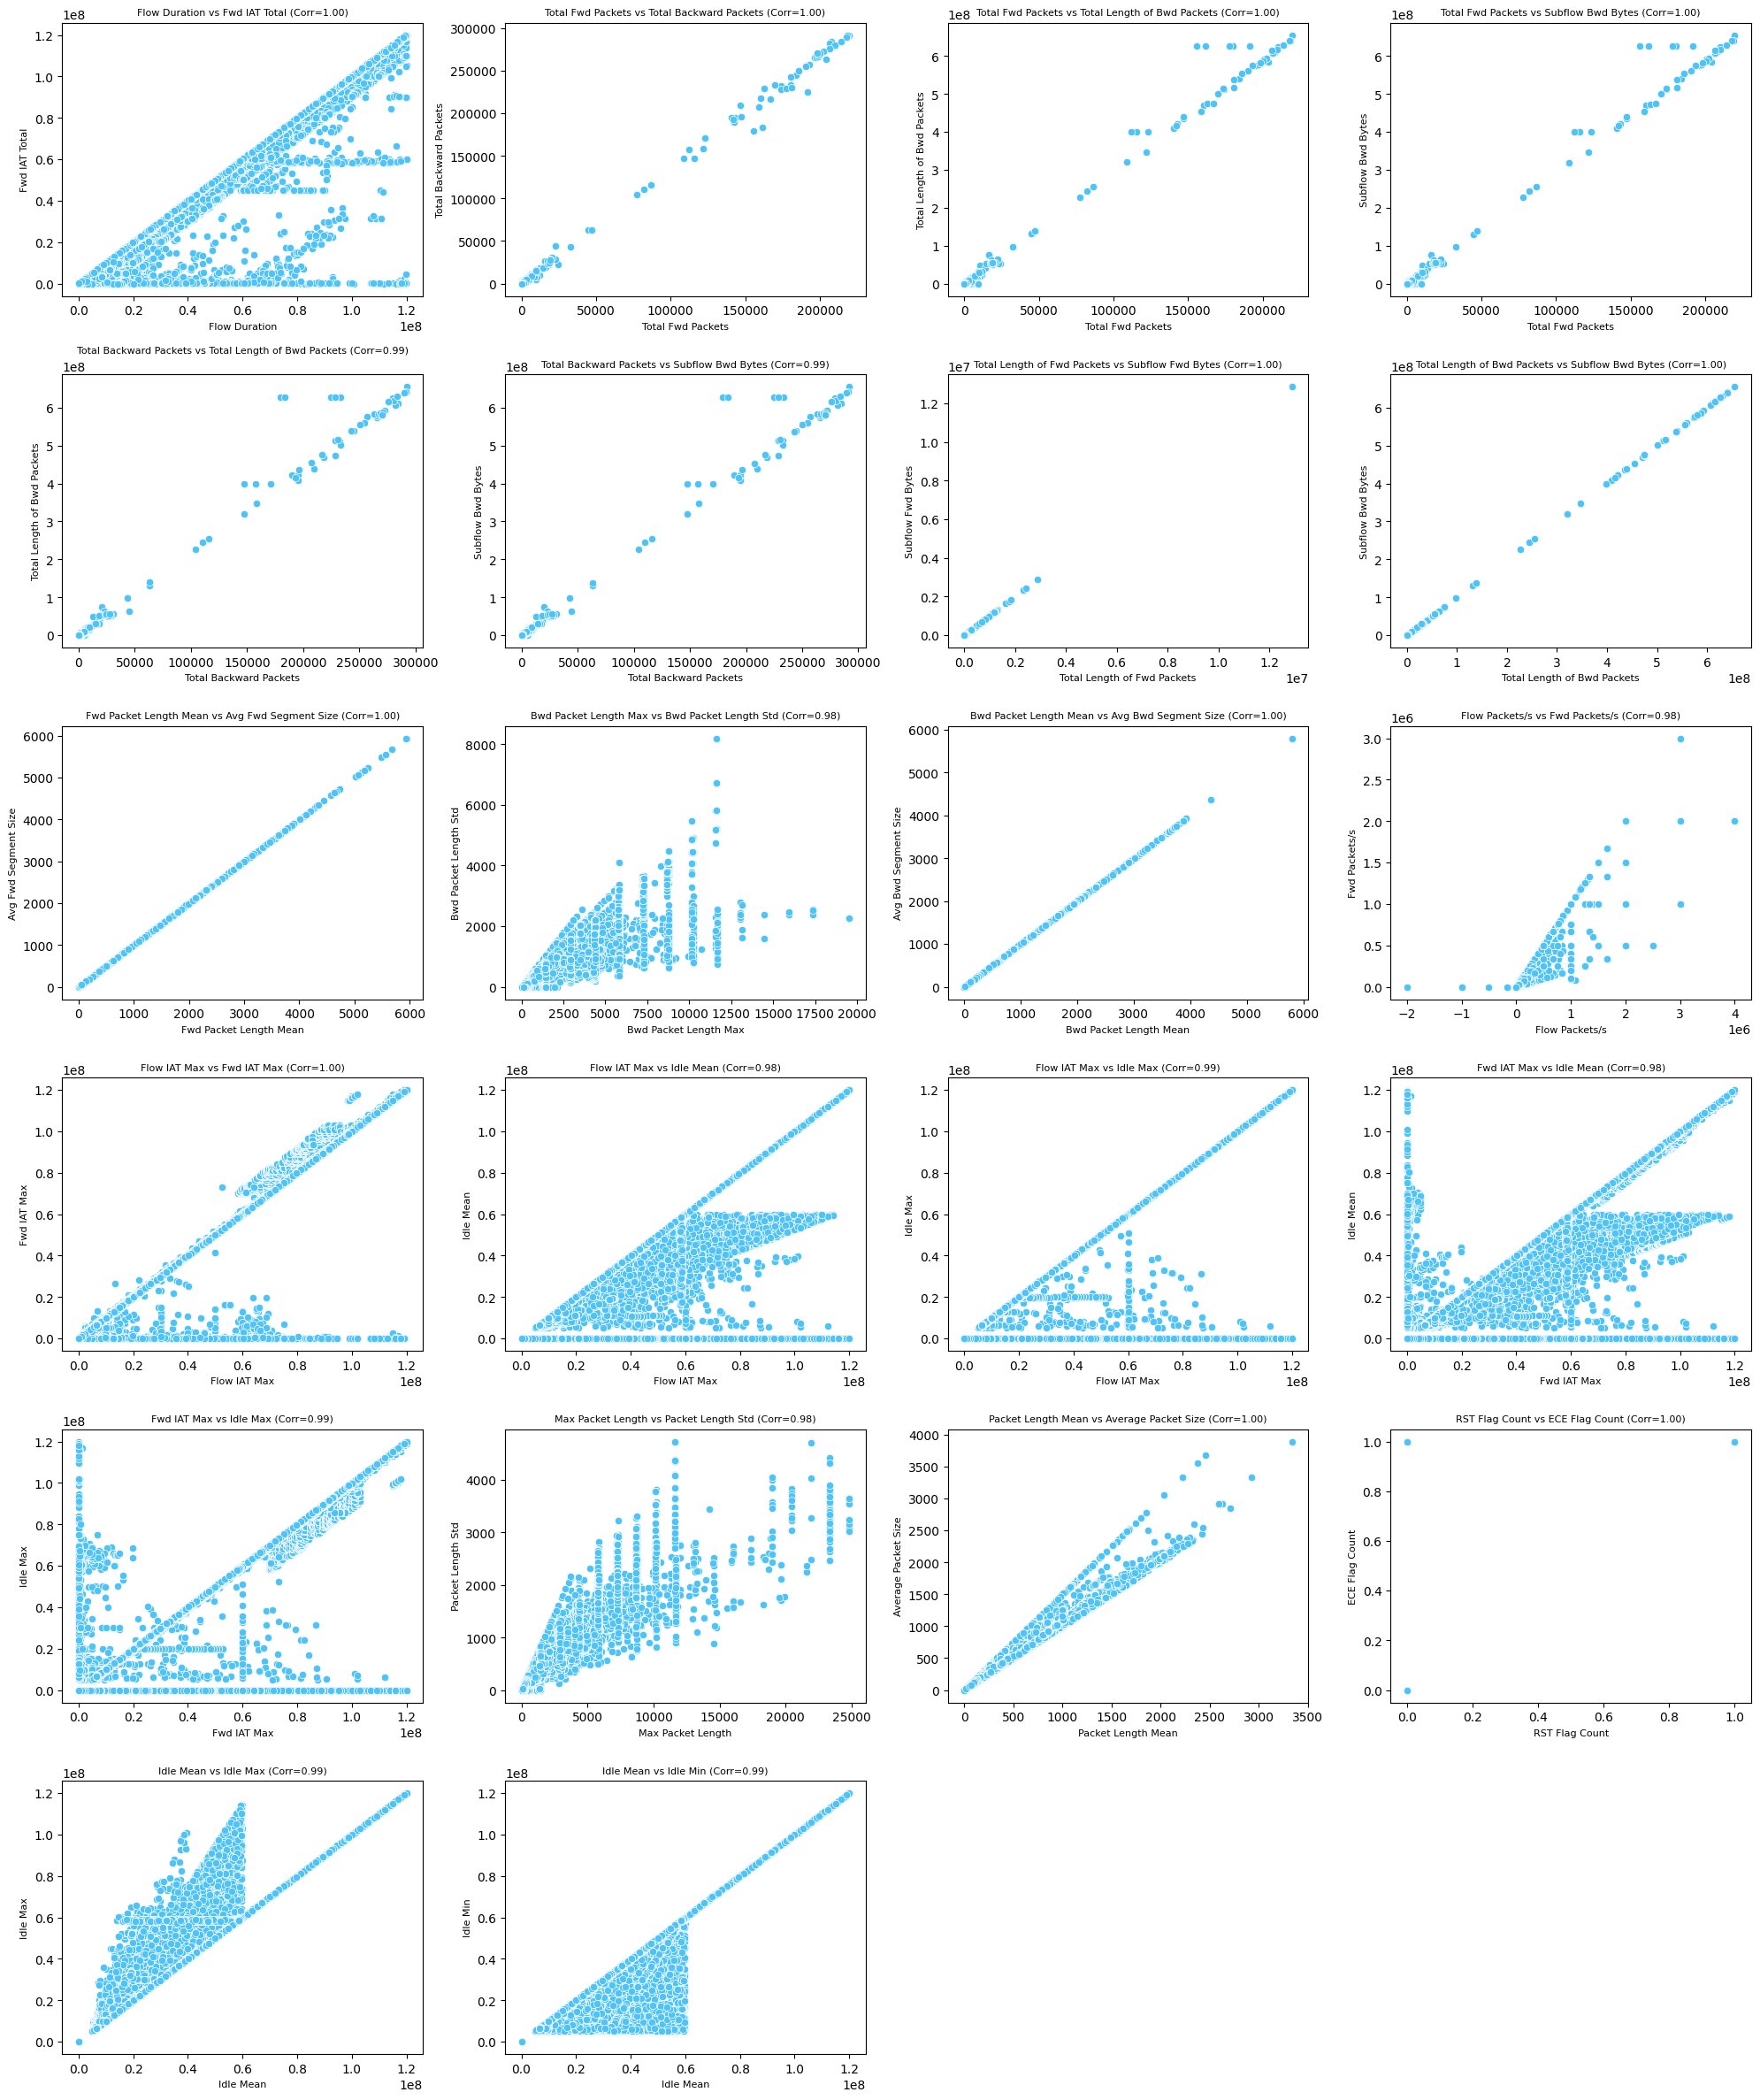

In [ ]:
num_features = get_feature_types(raw_df)
corr_matrix, high_corr_pairs = simple_corr(raw_df, num_features)


In [ ]:
'''
jika dilihat terdapat fitur yang memiliki bentuk yang mirip/kembar
Total Fwd Packets x Total Length of Bwd Packets
Total Fwd Packets x Subflow Bwd Bytes
Total Backward Packets x Total Length of Bwd Packets
Total Backward Packets x Subflow Bwd Bytes

berupa scaterplot lurus pada
Total Fwd Packets x Total Backward Packets
Total Length of Bwd Packets x Subflow Bwd Bytes
Fwd Packet Length Mean x Avg Fwd Segment Size
Bwd Packet Length Mean x Avg Bwd Segment Size

sehingga dapat dihapus
Avg Fwd Segment Size, Avg Bwd Segment Size, Subflow Bwd Bytes, Total Length of Bwd Packets, Total Backward Packets
'''
# drop fitur yang dipilh
raw_df = raw_df.drop(columns=[
    'Avg Fwd Segment Size',
    'Avg Bwd Segment Size',
    'Subflow Bwd Bytes',
    'Total Length of Bwd Packets',
    'Total Backward Packets'
])
raw_df.shape

(2520798, 61)

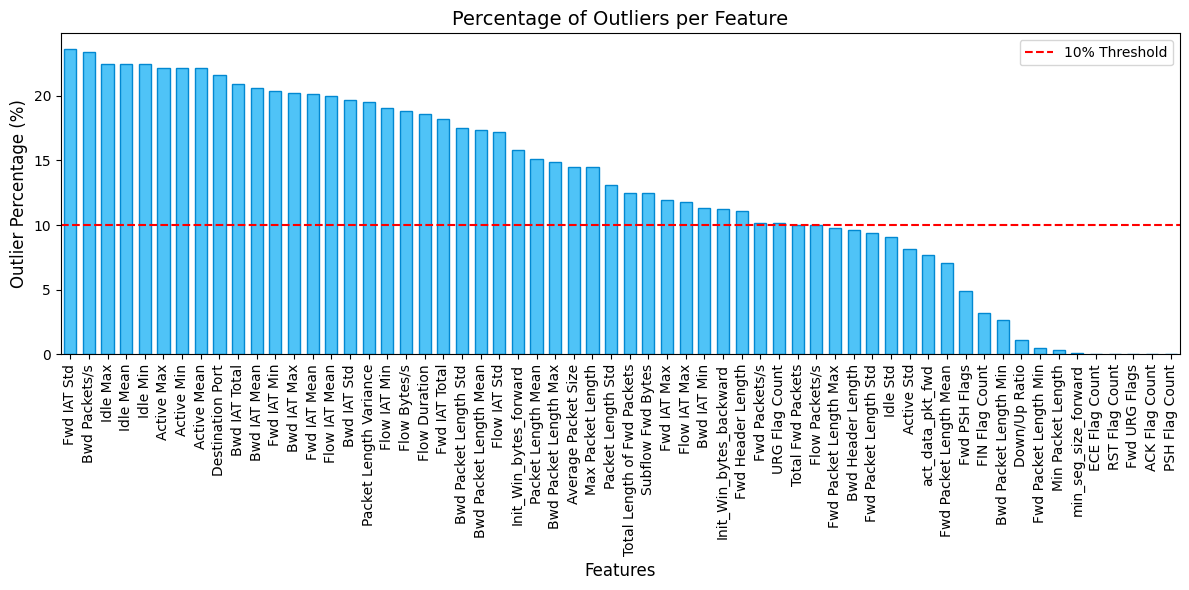

,0
Fwd IAT Std,23.658302
Bwd Packets/s,23.401954
Idle Max,22.502200
Idle Mean,22.502200
Idle Min,22.502200
Active Max,22.168575
Active Min,22.168575
Active Mean,22.168575
Destination Port,21.644733
Bwd IAT Total,20.928055


In [ ]:
# cek outlier -> mentukan scaler
def simple_outlier(df, fitur, threshold=10):
    out = {}
    for col in fitur:
        s = df[col].dropna()
        if s.empty:
            out[col] = 0.0
            continue
        q1, q3 = s.quantile([0.25, 0.75])
        iqr = q3 - q1
        low = q1 - 1.5 * iqr
        high = q3 + 1.5 * iqr
        out[col]= ((s < low) | (s > high)).mean() * 100

    out = pd.Series(out).sort_values(ascending=False)

    plt.figure(figsize=(12, 6))
    x = np.arange(len(out))

    plt.bar(
        x,
        out.values,
        color="#4FC3F7",       # cool blue
        edgecolor="#0288D1",
        width=0.65
    )

    # REMOVE GAP: set xlim exactly to bar edges
    plt.xlim(-0.5, len(out) - 0.5)

    plt.axhline(threshold, color='red', linestyle='--', linewidth=1.5,
                label=f'{threshold}% Threshold')

    plt.title("Percentage of Outliers per Feature", fontsize=14)
    plt.ylabel("Outlier Percentage (%)", fontsize=12)
    plt.xlabel("Features", fontsize=12)

    plt.xticks(x, out.index, rotation=90, fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return out

num_features = get_feature_types(raw_df)
simple_outlier(raw_df, num_features)


karena punya banyak outliner lebih dari 10%, proses normalisasi menggunakan robust scaler dipilih RobustScaler bekerja berdasarkan median dan IQR sehingga lebih tahan terhadap nilai ekstrem dibandingkan StandardScaler dan MinMaxScaler.

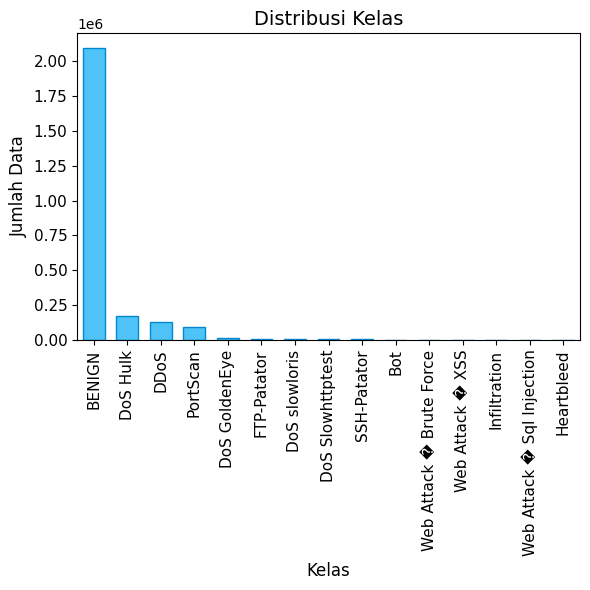

,Jumlah,Persen (%)
Label,,
BENIGN,2095057,83.11
DoS Hulk,172846,6.86
DDoS,128014,5.08
PortScan,90694,3.60
DoS GoldenEye,10286,0.41
FTP-Patator,5931,0.24
DoS slowloris,5385,0.21
DoS Slowhttptest,5228,0.21
SSH-Patator,3219,0.13


In [ ]:
# cek imbalance
def simple_imbalance(df, col_label="Label"):
    class_count = df[col_label].value_counts()
    pct = (class_count / len(df) * 100).round(2)

    imbalance = pd.DataFrame({
        "Jumlah": class_count,
        "Persen (%)": pct
    })
    # plot batang
    # posisi bar
    x = np.arange(len(class_count))

    plt.figure(figsize=(6,6))

    # bar chart dengan cool blue
    plt.bar(
        x,
        class_count.values,
        color="#4FC3F7",      # Cool Blue
        edgecolor="#0288D1",
        width=0.65
    )

    # hilangkan gap kiri kanan
    plt.xlim(-0.5, len(class_count) - 0.5)

    # label & title
    plt.title("Distribusi Kelas", fontsize=14)
    plt.ylabel("Jumlah Data", fontsize=12)
    plt.xlabel("Kelas", fontsize=12)

    plt.xticks(x, class_count.index, rotation=90, fontsize=11)
    plt.yticks(fontsize=11)

    plt.tight_layout()
    plt.show()

    return imbalance
simple_imbalance(raw_df, "Label")

terlihat dataset sangat tidak seimbang. banyak dataset dibawah 0.1%. banyak serangan terpecah sehingga perlu regroup agar data lebih stabil
perlu dilakukannya balancing

In [ ]:
# cek levene -> menentukan cariansi antar kelas homogen atau tidak
def simple_levene(df, numeric_features, target_col='Label'):
    res = {}
    groups_df = list(df.groupby(target_col))
    for f in numeric_features:
        groups = [g[f].dropna().values for _, g in groups_df]
        groups = [g for g in groups if len(g) > 0 and np.var(g) > 0]
        if len(groups) < 2:
            continue
        stat, p = stats.levene(*groups)
        res[f] = {'stat': stat, 'p': p}
    return pd.DataFrame(res).T.sort_values('p')

simple_levene(raw_df, num_features)

,stat,p
Destination Port,8607.456863,0.000000e+00
Flow Duration,3339.470632,0.000000e+00
Total Length of Fwd Packets,3342.507036,0.000000e+00
Fwd Packet Length Max,1836.209661,0.000000e+00
Fwd Packet Length Mean,1418.050261,0.000000e+00
Fwd Packet Length Min,4808.905868,0.000000e+00
Fwd Packet Length Std,1260.577594,0.000000e+00
Bwd Packet Length Max,92144.535749,0.000000e+00
Flow Packets/s,1396.389323,0.000000e+00
Bwd Packet Length Min,26441.270691,0.000000e+00


Berdasarkan hasil Levene Test, hampir seluruh fitur memiliki nilai p-value < 0.05, yang menunjukkan bahwa variansi antar kelas tidak homogen. Hanya tiga fitur (min_seg_size_forward, Bwd Header Length, dan Fwd Header Length) yang memiliki variansi homogen. Karena mayoritas fitur gagal memenuhi asumsi homogenitas variansi, metode ANOVA tidak sesuai digunakan. Oleh karena itu, proses feature importance menggunakan metode non-parametrik Kruskal–Wallis.

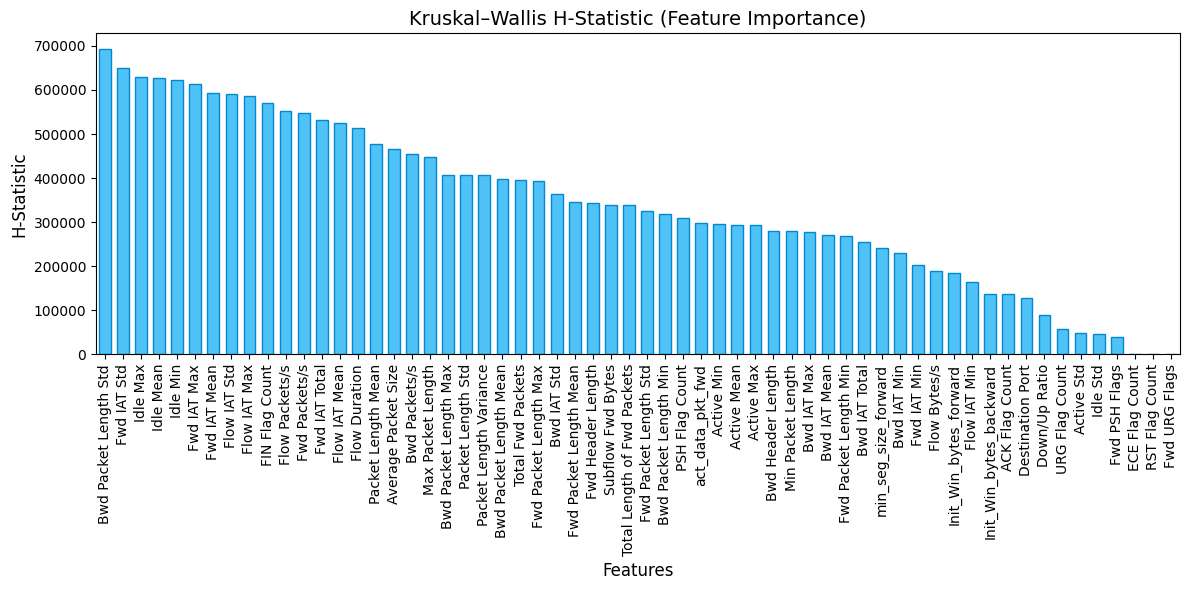

In [ ]:
# caek fitur importance
def simple_kw(df, numeric_features, target_col='Label'):
    res = {}
    groups_df = list(df.groupby(target_col))
    for f in numeric_features:
        groups = [g[f].dropna().values for _, g in groups_df]
        if sum(len(g) > 0 for g in groups) < 2:
            continue
        h, p = stats.kruskal(*groups)
        res[f] = {'H': h, 'p': p}

    df_kw = pd.DataFrame(res).T
    df_kw = df_kw.sort_values('H', ascending=False)

    x = np.arange(len(df_kw))

    plt.figure(figsize=(12, 6))

    # bar COOL BLUE
    plt.bar(
        x,
        df_kw["H"].values,
        color="#4FC3F7",      # Cool Blue
        edgecolor="#0288D1",
        width=0.65
    )

    # NO GAP kiri & kanan
    plt.xlim(-0.5, len(df_kw) - 0.5)

    # label & title
    plt.title("Kruskal–Wallis H-Statistic (Feature Importance)", fontsize=14)
    plt.ylabel("H-Statistic", fontsize=12)
    plt.xlabel("Features", fontsize=12)

    plt.xticks(x, df_kw.index, rotation=90, fontsize=10)
    plt.yticks(fontsize=10)

    plt.tight_layout()
    plt.show()

    return df_kw

df_kw = simple_kw(raw_df, num_features)

h besar -> penting
h kecil -> boleh dihapus

fitur yang dapat dihapus
ECE Flag Count
RST Flag Count
Fwd URG Flags

In [ ]:
fitur_kecil = df_kw.nsmallest(10, 'H').index.tolist()
print(fitur_kecil)

['Fwd URG Flags', 'RST Flag Count', 'ECE Flag Count', 'Fwd PSH Flags', 'Idle Std', 'Active Std', 'URG Flag Count', 'Down/Up Ratio', 'Destination Port', 'ACK Flag Count']


gunakan violin plot untuk melihat distribusi data


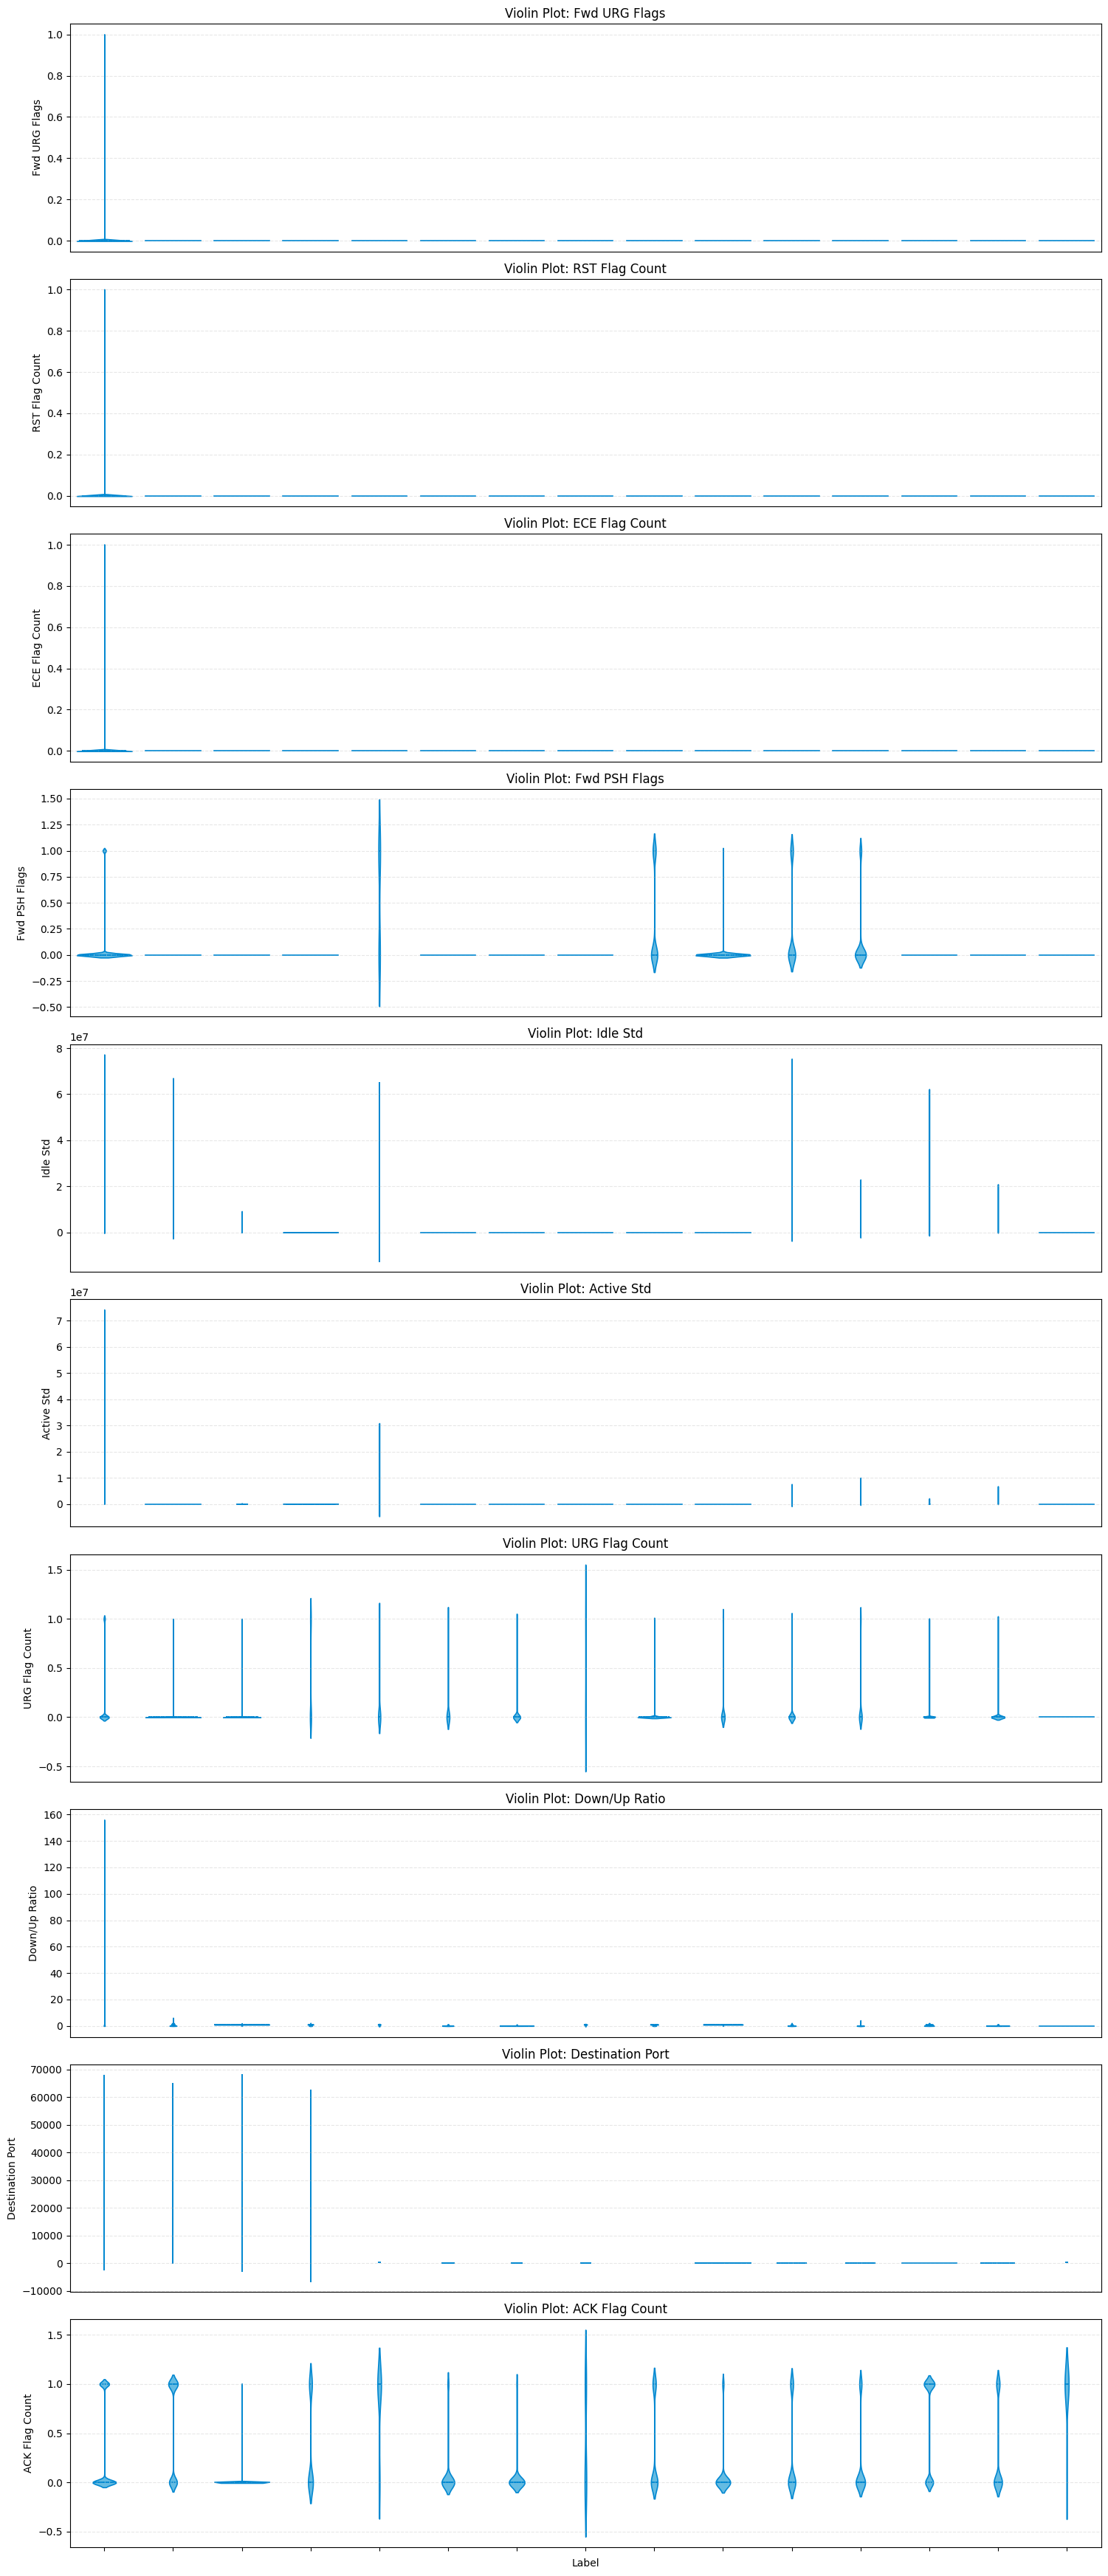

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# pastikan cuma fitur yang masih ada di raw_df
fitur_kecil = [f for f in fitur_kecil if f in raw_df.columns]

fig, axes = plt.subplots(len(fitur_kecil), 1,
                         figsize=(15, 3.5 * len(fitur_kecil)),
                         sharex=True)

for i, f in enumerate(fitur_kecil):
    sns.violinplot(data=raw_df, x='Label', y=f, inner='quartile', ax=axes[i],color="#4FC3F7", linewidth=1.2, edgecolor="#0288D1")
    axes[i].set_title(f'Violin Plot: {f}', fontsize=12)

    if i != len(fitur_kecil) - 1:
        axes[i].set_xlabel('')
        axes[i].tick_params(axis='x', which='both', length=0)
        axes[i].set_xticklabels([])
    else:
        axes[i].set_xlabel('Label')
        axes[i].tick_params(axis='x', rotation=90, labelsize=8)
    axes[i].grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


dari 10 fitur terkecil kw terdapat 8 fitur yang perlu dihapus karena hampir 0 tidak ada variasi 'Fwd URG Flags', 'RST Flag Count', 'ECE Flag Count', 'Fwd PSH Flags', 'Idle Std', 'Active Std', 'URG Flag Count', 'Down/Up Ratio'

In [ ]:
# drop fitur yang dipilh
raw_df = raw_df.drop(columns=[
    'Fwd URG Flags',
    'RST Flag Count',
    'ECE Flag Count',
    'Fwd PSH Flags',
    'Idle Std',
    'Active Std',
    'URG Flag Count',
    'Down/Up Ratio',
])
raw_df.shape
final_features = raw_df.columns.tolist()
print(raw_df.shape)
print("Jumlah fitur:", len(final_features))
print("\nDaftar fitur yang digunakan:\n")
for f in final_features:
    print("-", f)


(2520798, 53)
Jumlah fitur: 53

Daftar fitur yang digunakan:

- Destination Port
- Flow Duration
- Total Fwd Packets
- Total Length of Fwd Packets
- Fwd Packet Length Max
- Fwd Packet Length Min
- Fwd Packet Length Mean
- Fwd Packet Length Std
- Bwd Packet Length Max
- Bwd Packet Length Min
- Bwd Packet Length Mean
- Bwd Packet Length Std
- Flow Bytes/s
- Flow Packets/s
- Flow IAT Mean
- Flow IAT Std
- Flow IAT Max
- Flow IAT Min
- Fwd IAT Total
- Fwd IAT Mean
- Fwd IAT Std
- Fwd IAT Max
- Fwd IAT Min
- Bwd IAT Total
- Bwd IAT Mean
- Bwd IAT Std
- Bwd IAT Max
- Bwd IAT Min
- Fwd Header Length
- Bwd Header Length
- Fwd Packets/s
- Bwd Packets/s
- Min Packet Length
- Max Packet Length
- Packet Length Mean
- Packet Length Std
- Packet Length Variance
- FIN Flag Count
- PSH Flag Count
- ACK Flag Count
- Average Packet Size
- Subflow Fwd Bytes
- Init_Win_bytes_forward
- Init_Win_bytes_backward
- act_data_pkt_fwd
- min_seg_size_forward
- Active Mean
- Active Max
- Active Min
- Idle Mean
- Id